### Imports & Downloads


In [1]:
# Data
import sqlite3
import json
import wandb

import spacy
from spacy.lang.en import English
from spacy.pipeline import EntityRuler
import re
from spacy import displacy
from collections import Counter
import matplotlib.pyplot as plt

import numpy as np
from datetime import timedelta
import pandas as pd
import random
import os

%run "../src/ner_fns.py"
%run "../src/helper_fns.py"

In [2]:
# !wget "https://static.stooq.com/db/h/tqobcntmx5id8gas3f61p2kluvwr7j9y/d_us_txt.zip"
# !wget "https://doc-0c-18-docs.googleusercontent.com/docs/securesc/canqtt7b9jpk8a9r3ucjk6vphoout6s7/6amolpg8l7u4s0esql29ss5e7gnfv2as/1682760225000/04500760608179366517/13203297343859703330/0B3C8GEFwm08Qa1hvdnp2YmFPeHc?e=download&ax=ALy03A6PdFRfb6CHC4BAoaaAuRWpgcW-Gp7xhoMwywuPkerHAi4fj0u5vRPLlUDSmgXTdxjs3KV7924rK1Fm_jgRlBbAgoJk7v_0VXNM-dt-tEOHDfrXca5nZVqhtZUYAX62Tjre4B-hiU1FpXBEB5PBa1-ClLBlyWpbctJEZ89jxox5gVF8S5zezHJsieiNECq7rnw0hy6ChG71dNjIjsDFMgYrdX0W2lrREzD5p9BcGdnXfOYuI8D_SWh3qcjv90UOTBGUSJF_kXVQQ0pmkkL_E23xo8jWx71Fy0mU98s6LwMgwbOHL0gK2GNV2SyOlXL8Au9t95uJy4fKIgxiUht5MgksVHqg-vxEV7yV7295ovYiSO36gnWz36ryIrx9XZ6HArG0FxDqev6afRSsnfTDBRE_7KbTOC1y-D2XrFCS2ny0K3n25wYscBGqwpAX7IUXmo7l7Z22gdwrNtsqyj3jLSIxtgcgdCV0ObkPe_Ujh1PtwOdP_J6V1BRWzjP5Jj-x6GrJxyBAxscq8N0B_LfVmL9iEeQI92IOGcfNqDw2NFnAGH2oP5c3eys_ac7_GH7f8cUzXDB6M2nIf_cHJgPBHYZ9zF0PC78G3ONdxF2oYOIxdFYXR31DOTUwTW4Z7KmdT3v3vm781aB3NvdKQ0Rpd2R3v7jpcsCNFFcTPHJtYDu2vWDvx950DYEozZW53lGa6a5MXR4tBnkk6CzKbqZLolonpNoFlLpoSlA3-96p45l7EF4HeWf5In6IM0M45D44eAPnDoIvB-_XJaL_lYekiwuGAS-8LZoCUnyuKZeDpIN0ceCWdNukyEGSM8ILVMgBCUqO2jNgaGv5NTh8aYdEF84-2E9LmZp5breahaMGwfsbJ5GnV3aOpGk1a66CIDb8l4CJpuU56XJv_sbgkG-5YxYen1hC6SBCQTr6SLMb22baxQrxz6ZmKIt50Ide8DWtitaASOvnxHYDOcxkjjSnsLCD6RDA&uuid=5534d18a-690f-49f9-b8fa-e193a0e71c45&authuser=0&resourcekey=0-moaUOlN-Y5aGPxVMhg-B2A&nonce=26g50k954sna4&user=13203297343859703330&hash=b9cbt1gr4rc1vkhmvbcn5p6nd9151igb"

### Access Nasdaq Screener from Database


In [3]:
con = sqlite3.connect("../../data/FDB.db")
sql_query = """SELECT name FROM sqlite_master
    WHERE type='table';"""
cursor = con.cursor()

cursor.execute(sql_query)
tables = [x[0] for x in cursor.fetchall()]
sql_query = """SELECT * FROM 'us_equities_news_dataset'  """
cursor.execute(sql_query)
news = cursor.fetchall()

# Create your connection.
dfs = {}
t = "nasdaq_screener"
dfs[t] = pd.read_sql_query(f"SELECT * FROM {t}", con)

# We chose Sector over Industry as it is more general

# Remove Nulls
dfs[t].dropna(
    subset=["Sector", "Symbol"], inplace=True
)  # Dropped from 684 to 658 company

config = read_config_file("../config_files/data_preprocessing_config.json")

### Training NER Model


In [6]:
# create Json file that contains companies names
name_json = json.dumps(list(dfs["nasdaq_screener"]["Name"].unique()), indent=2)
with open(config["companies_names"], "w") as outfile:
    outfile.write(name_json)

# create Json file that contains companies symbol
symbol_json = json.dumps(list(dfs["nasdaq_screener"]["Symbol"].unique()), indent=2)
with open(config["companies_symbols"], "w") as outfile:
    outfile.write(symbol_json)

In [24]:
updated_names = generate_better_names(config["companies_names"])
updated_name_json = json.dumps(updated_names, indent=2)

with open(config["updated_names"], "w") as outfile:
    outfile.write(updated_name_json)

with open(config["companies"], "w") as outfile:
    outfile.write(
        "{}".format(
            ",".join(
                [
                    open("../../data/trained_files/json/updated_names.json", "r").read()[:-1],
                    open("../../data/trained_files/json/companies_symbol.json", "r").read()[1:],
                ]
            )
        )
    )


# Generate Rules
patterns = create_training_data(
    config["updated_names"], list(dfs["nasdaq_screener"]["Symbol"])
)
# Save trained_ner to disk
generate_rules(patterns, config["trained_ner"])

658


In [9]:
# News Data
nlp = spacy.load(config["trained_ner"])

In [15]:
config["nasdaq_stocks"]+"/{i}/{k}".format(i=1, k=1)

'../../data/d_us_txt/data/daily/us/nasdaq stocks/1/1'

### Historical Data


In [14]:
# Downloaded d_us_txt from Stooq
temp = []
for i in range(1, 4):
    for k in os.listdir(config["nasdaq_stocks"]+"/{i}".format(i=i)):
        # symbol	dateOfPrice	open	high	low	close	volume
        temp.append(
            pd.read_csv(
                config["nasdaq_stocks"]+"/{i}/{k}".format(i=i, k=k),
                sep=",",
                header=0,
                names=[
                    "symbol",
                    "<PER>",
                    "dateOfPrice",
                    "<TIME>",
                    "open",
                    "high",
                    "low",
                    "close",
                    "volume",
                    "<OPENINT>",
                ],
            )
        )

all_stocks = pd.concat(temp)
del temp
all_stocks.columns = [
    "symbol",
    "<PER>",
    "dateOfPrice",
    "<TIME>",
    "open",
    "high",
    "low",
    "close",
    "volume",
    "<OPENINT>",
]

In [15]:
"""
date was in the format of
20190101
day is first 2 digits month is the 2nd 2 digits
"""
import datetime


def to_datetime(x: int):
    day = x % 100
    x = x // 100
    month = x % 100
    year = x // 100
    return datetime.datetime(year, month, day)


all_stocks["dateOfPrice"] = all_stocks["dateOfPrice"].apply(to_datetime)

# Sort by date
all_stocks = all_stocks.sort_values(["dateOfPrice"])

### News Dataset & Combination


In [16]:
# DFS will have 2 columns:
# 1. News that consists of id', 'symbol', 'title', 'category', 'content', 'release_date', 'provider', 'url', 'article_id'
# 2. Stock History that consists of 'symbol', 'dateOfPrice', 'open', 'high', 'low', 'close', 'volume'

dfs["news"] = pd.read_csv(config["news_dataset"])
dfs["news"]["release_date"] = pd.to_datetime(dfs["news"]["release_date"])
dfs["news"].columns = [k if k != "ticker" else "symbol" for k in dfs["news"].columns]
dfs["stockHistory"] = all_stocks

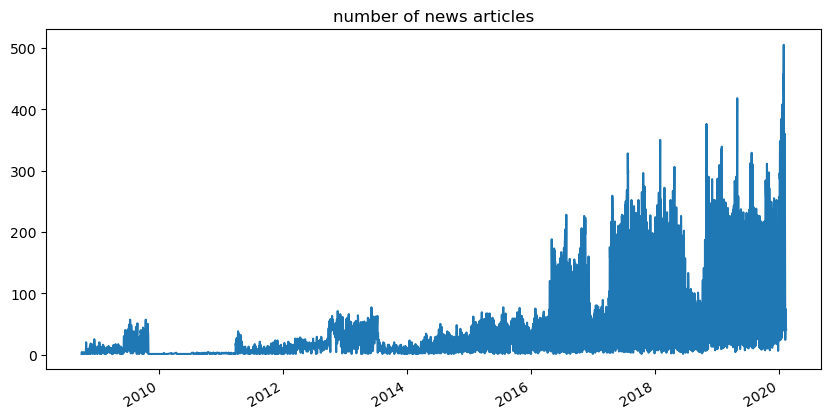

In [ ]:
plt.figure(figsize=(10, 5))
dfs["news"]["release_date"].value_counts().sort_index().plot()
# plt.ylabel("number of news articles")
plt.title("number of news articles")
plt.show()

### Filteration & Matching Datasets


In [19]:
# we have historical data from 1970 and later
# # we also have news till 2020

# Make the matching between the news and the stock history

# filtering by selecting rows where the "dateOfPrice" is less than or equal to the maximum "release_date" from the dfs["news"] dataframe plus 7 days
stock_df = dfs["stockHistory"][
    dfs["stockHistory"]["dateOfPrice"]
    <= dfs["news"]["release_date"].max() + timedelta(7)
]

# filtering by selecting rows where the "dateOfPrice" is greater than or equal to the minimum "release_date" from the dfs["news"] dataframe minus 7 days
stock_df = stock_df[
    stock_df["dateOfPrice"] >= datetime.datetime(2015, 1, 1) - timedelta(7)
]

news_df = dfs["news"][
    dfs["news"]["release_date"] >= datetime.datetime(2015, 1, 1) - timedelta(7)
]
news_df.drop(["provider"], axis=1, inplace=True)

C:\Users\miret\AppData\Local\Temp\ipykernel_24472\1270728149.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_df.drop(["provider"], axis=1, inplace=True)


In [20]:
## Matching Both Datasets

stock_df["symbol"] = stock_df["symbol"].apply(lambda x: x[:-3] if ".us" in x.lower() else  x)
stock_history_symbols = stock_df.symbol.unique()
news_symbols = news_df.symbol.unique()
nasdaq_screener_symbols = dfs["nasdaq_screener"]["Symbol"].unique()

target_symbols = [ k for k in news_symbols if k in stock_history_symbols and k in nasdaq_screener_symbols]

# Shape of news_df is 82328 rows × 9 columns

news_df = news_df.dropna(subset=["content","title","category","release_date", "symbol"])

# Dropping companies that are not in stock_df or not in news_df
news_df = news_df[news_df["symbol"].isin(target_symbols)]
stock_df = stock_df[stock_df["symbol"].isin(target_symbols)]


print(len(target_symbols)) , print(len(news_symbols)), print(len(stock_history_symbols))

# Generating a column with mentioned companies in each article
news_df["mentioned_companies"] = news_df.apply(lambda x:[ org for org in get_companies(x["content"], nlp) if (org.strip() !=  x["symbol"] and  org.strip() in target_symbols)], axis= 1 )

# Filter Nasdaq Screener
dfs["nasdaq_screener"] = dfs["nasdaq_screener"][dfs["nasdaq_screener"]["Symbol"].isin(target_symbols)]

dfs["stockHistory"] = stock_df
dfs["news"] = news_df
print(len(dfs["stockHistory"]["symbol"].unique()) == len(dfs["news"]["symbol"].unique()))

310
796
2516
True


In [ ]:
# Saving to Disk
dfs["news"].to_csv(config["processed_news_df"])
dfs["stockHistory"].to_csv(config["processed_stock_df"]])
dfs["nasdaq_screener"].to_csv(config["nasdaq_screener"])